# Layered Model Starter Code

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Topography
- Land surface 100m above the datum on the left hand side
- sloping linearly to 85m above the datum on the right hand side

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Left boundary constant head 85m
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 5E-5 m/d uniformly across the domain
 
#### Well: 
 - Pumping well
     - Located at (2500, 2500)
     - Pumping at a rate of 500 m^3/day 

#### Layered Scenario
 - Low K layer - Kx=Ky=Kz=0.0001m/d
 - Extends from 25-35m above the base of the domain
 - The well is only completed in the lowest layer
     

## 1. Setup the environment

In [100]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [101]:
## model directory
moddir = "C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe"

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x direction 
dy= 100 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
#print(ztop.shape)
# print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop.copy() - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_horiz = 1.    #assign horizontal hydraulic conductivity 
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## Recharge
recharge = 5e-5 #m/day

## Well
pumping = -500 #m3/day  #given
well_xy= [2500, 2500] #xy location of well 
well_row = np.floor((nrow-1)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx-1) #convert the x location to a column
well_loc = (0,well_row,well_col) #Well loc should be layer, row, column
print(well_loc)
#print(well_col)


## Boundary conditions
h_left = 85
h_right = 70

(0, 24.0, 24.0)


## 3. Setup and run MODFLOW for the one layer scenario 

In [102]:
#Initialize the model
modelname1 = "OneLayer"

m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1         #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))  #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)  #create rch object

#Well
well_1 = [i for i in well_loc] + [pumping]
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]}
wel = flopy.modflow.ModflowWel(model=m1, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)

#write the inputs
m1.write_input()    

#Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


Well 1 [layer, row, column, flux]: 
 [0, 24.0, 24.0, -500]
FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: OneLayer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/06 21:13:02

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/06 21:13:02
 Elapsed run time:  0.057 Seconds

  Normal termination of simulation


## 4. Setup and run MODFLOW for the three layer scenario 

#### 4.2 Three layers, well in top layer (based on discussion group's notebook)

In [103]:
#Initialize the model
modelname3_top = "ThreeLayer_top"
m3_top = flopy.modflow.Modflow(modelname3_top, exe_name = moddir)

## Make some changes to the parameters
nlay_3lay=3  #thre layers instead of 1
botm = np.zeros((nlay_3lay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 25.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 35.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3_top, nlay=nlay_3lay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay_3lay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay_3lay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m3_top, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3_top, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 
#lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=K_horiz,              #challenge 3 making K vals match single layer model
#                               vka=K_vert, ss=Ss,
#                               sy=Sy,storagecoefficient=True, ipakcb=53)



#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m3_top, rech=rech_zone, ipakcb=53)     #create rch object

#Well in top layer [0]
well_loc = (0,well_row,well_col) #Well loc should be layer, row, column
well_top = [i for i in well_loc] + [pumping]
print(well_top)
print("Well top [layer, row, column, flux]: \n", well_top)
wel_spd = {0: [well_top]} #putting the well in the bottom layer
wel = flopy.modflow.ModflowWel(model=m3_top, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3_top, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3_top)

#write the inputs
m3_top.write_input()    

#Run the model 
success, mfoutput = m3_top.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

[0, 24.0, 24.0, -500]
Well top [layer, row, column, flux]: 
 [0, 24.0, 24.0, -500]
FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: ThreeLayer_top.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/06 21:13:02

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/06 21:13:02
 Elapsed run time:  0.095 Seconds

  Normal termination of simulation


#### 4.2 Three layer, well in middle

In [104]:
#Initialize the model
modelname3_mid = "ThreeLayer_mid"
m3_mid = flopy.modflow.Modflow(modelname3_mid, exe_name = moddir)

## Make some changes to the parameters
nlay_3lay=3  #thre layers instead of 1
botm = np.zeros((nlay_3lay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 25.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 35.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3_mid, nlay=nlay_3lay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay_3lay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay_3lay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m3_mid, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3_mid, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 
#lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=K_horiz,              #challenge 3 making K vals match single layer model
#                               vka=K_vert, ss=Ss,
#                               sy=Sy,storagecoefficient=True, ipakcb=53)



#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m3_mid, rech=rech_zone, ipakcb=53)     #create rch object

#Well in middle layer [1]
well_loc = (1,well_row,well_col) #Well loc should be layer, row, column
well_mid = [i for i in well_loc] + [pumping]
print(well_mid)
print("Well middle [layer, row, column, flux]: \n", well_mid)
wel_spd = {0: [well_mid]} #putting the well in the bottom layer
wel = flopy.modflow.ModflowWel(model=m3_mid, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3_mid, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3_mid)

#write the inputs
m3_mid.write_input()    

#Run the model 
success, mfoutput = m3_mid.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

[1, 24.0, 24.0, -500]
Well middle [layer, row, column, flux]: 
 [1, 24.0, 24.0, -500]
FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: ThreeLayer_mid.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/06 21:13:03

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/06 21:13:03
 Elapsed run time:  0.106 Seconds

  Normal termination of simulation


### 4.3 Three layer, well at bottom

In [105]:
#Initialize the model
modelname3_bot = "ThreeLayer_bot"
m3_bot = flopy.modflow.Modflow(modelname3_bot, exe_name = moddir)

## Make some changes to the parameters
nlay_3lay=3  #thre layers instead of 1
botm = np.zeros((nlay_3lay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 25.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 35.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay_3lay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3_bot, nlay=nlay_3lay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay_3lay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head


#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay_3lay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m3_bot, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3_bot, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 
#lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=K_horiz,              #challenge 3 making K vals match single layer model
#                               vka=K_vert, ss=Ss,
#                               sy=Sy,storagecoefficient=True, ipakcb=53)



#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m3_bot, rech=rech_zone, ipakcb=53)     #create rch object

#Well in bottom layer [2]
well_loc = (2,well_row,well_col) #Well loc should be layer, row, column
well_bot = [i for i in well_loc] + [pumping]
print(well_bot)
print("Well bottom [layer, row, column, flux]: \n", well_bot)
wel_spd = {0: [well_bot]} #putting the well in the bottom layer
wel = flopy.modflow.ModflowWel(model=m3_bot, stress_period_data=wel_spd)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3_bot, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3_bot)

#write the inputs
m3_bot.write_input()    

#Run the model 
success, mfoutput = m3_bot.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

[2, 24.0, 24.0, -500]
Well bottom [layer, row, column, flux]: 
 [2, 24.0, 24.0, -500]
FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: ThreeLayer_bot.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/06 21:13:03

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/06 21:13:03
 Elapsed run time:  0.108 Seconds

  Normal termination of simulation


# 5. Plot the domains
### 5.1 Plan view of the domain

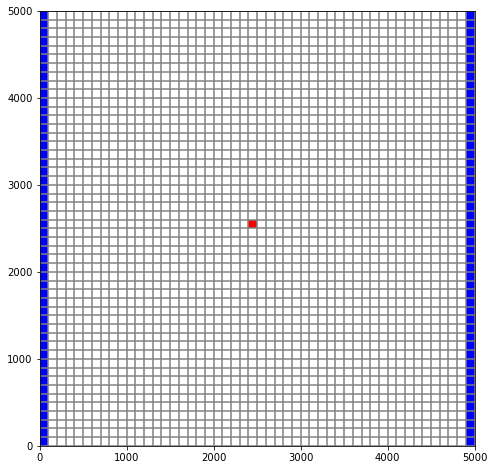

In [106]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m1)
ibound = mapview.plot_ibound()
wel = mapview.plot_bc("WEL")
linecollection = mapview.plot_grid()

### 5.2 Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

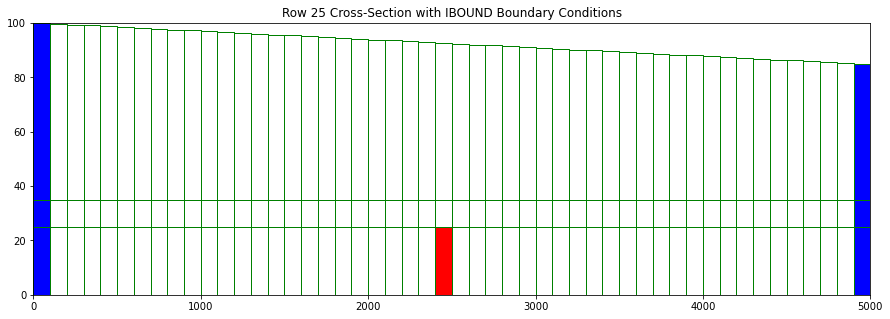

In [115]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3_bot, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

# 7. Read in the outputs

### 7.1 Modflow outputs - Heads and budget files

In [108]:
# Head - 1 layer model 
headobj1 = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times = headobj1.get_times()                 #returns a list of timesteps
head1 = headobj1.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model 
#headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
#times = headobj3.get_times()                 #returns a list of timesteps
#head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model, well top 
headobj3_0 = bf.HeadFile(modelname3_top+'.hds')    #reads the binary head file
times = headobj3_0.get_times()                 #returns a list of timesteps
head3_0 = headobj3_0.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model, well middle 
headobj3_1 = bf.HeadFile(modelname3_mid+'.hds')    #reads the binary head file
times = headobj3_1.get_times()                 #returns a list of timesteps
head3_1 = headobj3_1.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model, well bottom 
headobj3_2 = bf.HeadFile(modelname3_bot+'.hds')    #reads the binary head file
times = headobj3_2.get_times()                 #returns a list of timesteps
head3_2 = headobj3_2.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)


#Water balance - 1 layer
budgobj1 = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
print(budgobj1.get_unique_record_names())
kstpkper_list1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 


#Water balance - 3 layer
#budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
#print(budgobj3.get_unique_record_names())
#kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
#frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
#fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
#recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
#print(len(frf3))

#Water balance - 3 layer, Run 1
budgobj3_0 = bf.CellBudgetFile(modelname3_top+'.cbc')   #reads the cell budget file    
print(budgobj3_0.get_unique_record_names())
kstpkper_list3_0 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3_0 = budgobj3_0.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3_0 = budgobj3_0.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3_0 = budgobj3_0.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3_0))

#Water balance - 3 layer, Run 2
budgobj3_1 = bf.CellBudgetFile(modelname3_mid+'.cbc')   #reads the cell budget file    
print(budgobj3_1.get_unique_record_names())
kstpkper_list3_1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3_1 = budgobj3_1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3_1 = budgobj3_1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3_1.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3_1))

#Water balance - 3 layer, Run 3
budgobj3_2 = bf.CellBudgetFile(modelname3_bot+'.cbc')   #reads the cell budget file    
print(budgobj3_2.get_unique_record_names())
kstpkper_list3_2 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3_2 = budgobj3_2.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3_2 = budgobj3_2.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3_2.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3_2))


[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'        RECHARGE']
[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'        RECHARGE']
1
[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'        RECHARGE']
1
[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'        RECHARGE']
1


# 8. Plotting
### 8.1 Cross section plots

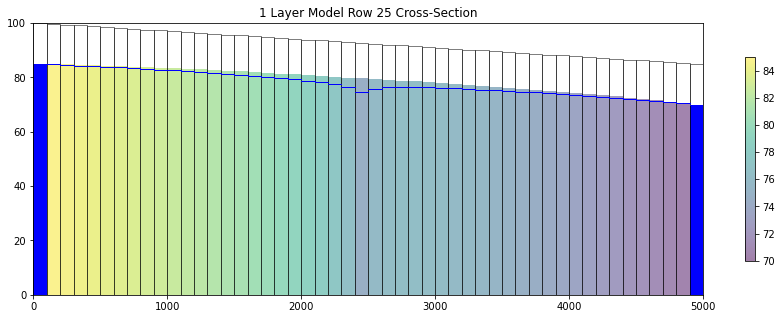

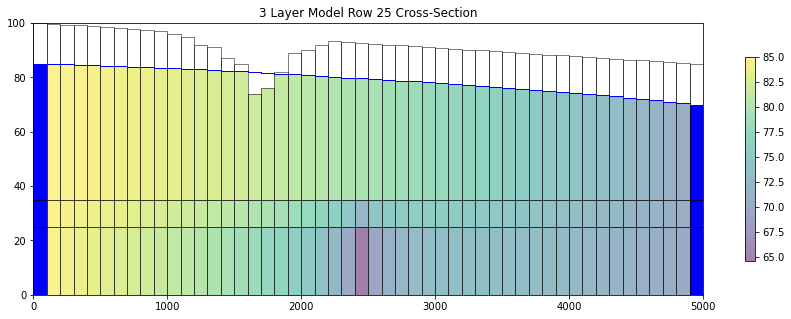

In [109]:
#### 1 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head1, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head1)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('1 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)


#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)


# 9. Additional plots
### 9.1 Plot head transect

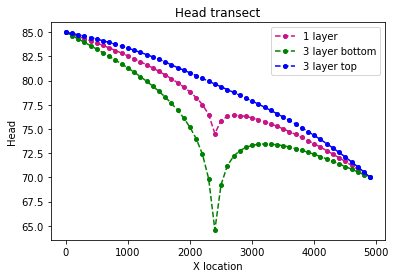

In [110]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0,5000,100) 
plt.plot(x,head1[0,int(well_row),:],marker='o', color='mediumvioletred', markersize=4, linestyle='--', label="1 layer")
plt.plot(x,head3[2,int(well_row),:],marker='o', color='green', markersize=4, linestyle='--', label="3 layer bottom")
plt.plot(x,head3[0,int(well_row),:],marker='o', color='blue', markersize=4, linestyle='--', label="3 layer top")
plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()

# plt.savefig('Head_Transect.png')

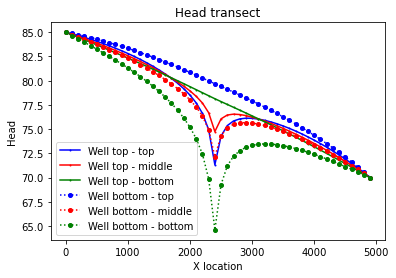

In [111]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)


x=np.arange(0,5000,100) 
## plt.plot(x,head1[0,int(well_row),:],marker='o', color='mediumvioletred', markersize=4, linestyle='--', label="1 layer")
plt.plot(x,head3_0[0,int(well_row),:],marker='o', color='blue', markersize=1,  label="Well top - top")  #linestyle='--',
plt.plot(x,head3_0[1,int(well_row),:],marker='o', color='r', markersize=1, label="Well top - middle")
plt.plot(x,head3_0[2,int(well_row),:],marker='o', color='green', markersize=1, label="Well top - bottom")

plt.plot(x,head3_2[0,int(well_row),:],marker='.',color='blue', markersize=8, linestyle=':', label="Well bottom - top")
plt.plot(x,head3_2[1,int(well_row),:], marker='.',color='r', markersize=8, linestyle=':', label="Well bottom - middle")
plt.plot(x,head3_2[2,int(well_row),:],marker='.', color='green', markersize=8, linestyle=':',label="Well bottom - bottom")


plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.rcParams["figure.figsize"] = (10,5)
plt.legend(prop={'size':10})

### 9.2 1 Layer Head Contours

C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


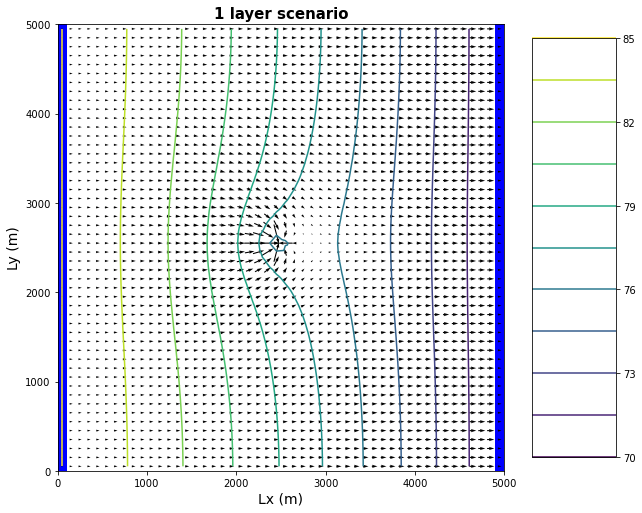

In [112]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m1, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf1[0], fff1[0], head=head1) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

In [113]:
#contour_levels = np.linspace(head1[0].min(),head1[0].max(),11) #set contour levels for contouring head  #is the first layer
print('shape head1', np.shape(head1))
print('shape head1[0]', np.shape(head1[0])) #how does [0] get rid of the layer dimension? ---is implied

shape head1 (1, 50, 50)
shape head1[0] (50, 50)


### 9.3 3 Layer head contours

C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\tento\Miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


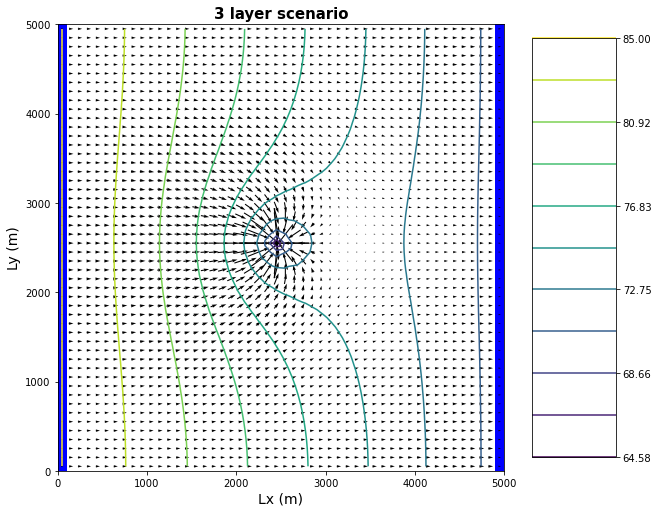

In [114]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3.min(),head3.max(),11) #set contour levels for contouring head #min and max of whole array, so same range per layer- could do per layer
#contour_levels = np.linspace(0,100,11) #set contour levels for contouring head
#print(head3.min(axis = 1))
head_contours = modelmap.contour_array(head3[2], levels=contour_levels) #create head contours #specifies which layer #what is actually plotting
flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

#print(head3)